In [4]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Sostituisci con il percorso del tuo file, ad esempio 'data/raw/S1/S1.pkl'
file_path = '/home/mmerone/mattia/ecg_generation/data/raw/S1.pkl'

with open(file_path, 'rb') as f:
    # Usiamo latin1 per compatibilità se il file è stato salvato con Python 2
    data = pickle.load(f, encoding='latin1')

print(f"Chiavi principali nel dizionario: {data.keys()}")

Chiavi principali nel dizionario: dict_keys(['rpeaks', 'signal', 'label', 'activity', 'questionnaire', 'subject'])


In [5]:
# Esplorazione dei metadati
print(f"ID Soggetto: {data['subject']}") 
print(f"Informazioni Soggetto: {data['questionnaire']}") 

# Esplorazione dei segnali
print("\nStruttura dei segnali ('signal'):")
print(f"Sorgenti disponibili: {data['signal'].keys()}") # Dovrebbe mostrare 'wrist' e 'chest' [cite: 116]

# Dettaglio segnali dal polso (Empatica E4)
wrist_signals = data['signal']['wrist']
print("\nSegnali dal Polso (Wrist):")
for key in wrist_signals.keys():
    shape = wrist_signals[key].shape
    print(f"- {key}: shape {shape}")
    # BVP è a 64Hz, ACC a 32Hz 

# Dettaglio segnali dal torace (RespiBAN)
chest_signals = data['signal']['chest'] 
print("\nSegnali dal Torace (Chest) - Campionati a 700 Hz:") 
for key in chest_signals.keys():
    print(f"- {key}: shape {chest_signals[key].shape}")

ID Soggetto: S1
Informazioni Soggetto: {'WEIGHT': 78.0, 'Gender': ' m', 'AGE': 34, 'HEIGHT': 182.0, 'SKIN': 3, 'SPORT': 6}

Struttura dei segnali ('signal'):
Sorgenti disponibili: dict_keys(['chest', 'wrist'])

Segnali dal Polso (Wrist):
- ACC: shape (294784, 3)
- BVP: shape (589568, 1)
- EDA: shape (36848, 1)
- TEMP: shape (36848, 1)

Segnali dal Torace (Chest) - Campionati a 700 Hz:
- ACC: shape (6448400, 3)
- ECG: shape (6448400, 1)
- EMG: shape (6448400, 1)
- EDA: shape (6448400, 1)
- Temp: shape (6448400, 1)
- Resp: shape (6448400, 1)


In [6]:
labels = data['label']
print(f"Numero di etichette HR (finestre di 8s): {len(labels)}")
print(f"Esempio di HR (bpm): {labels[:5]}")

Numero di etichette HR (finestre di 8s): 4603
Esempio di HR (bpm): [49.61136908 50.32399248 52.70833578 55.64079409 57.65840574]


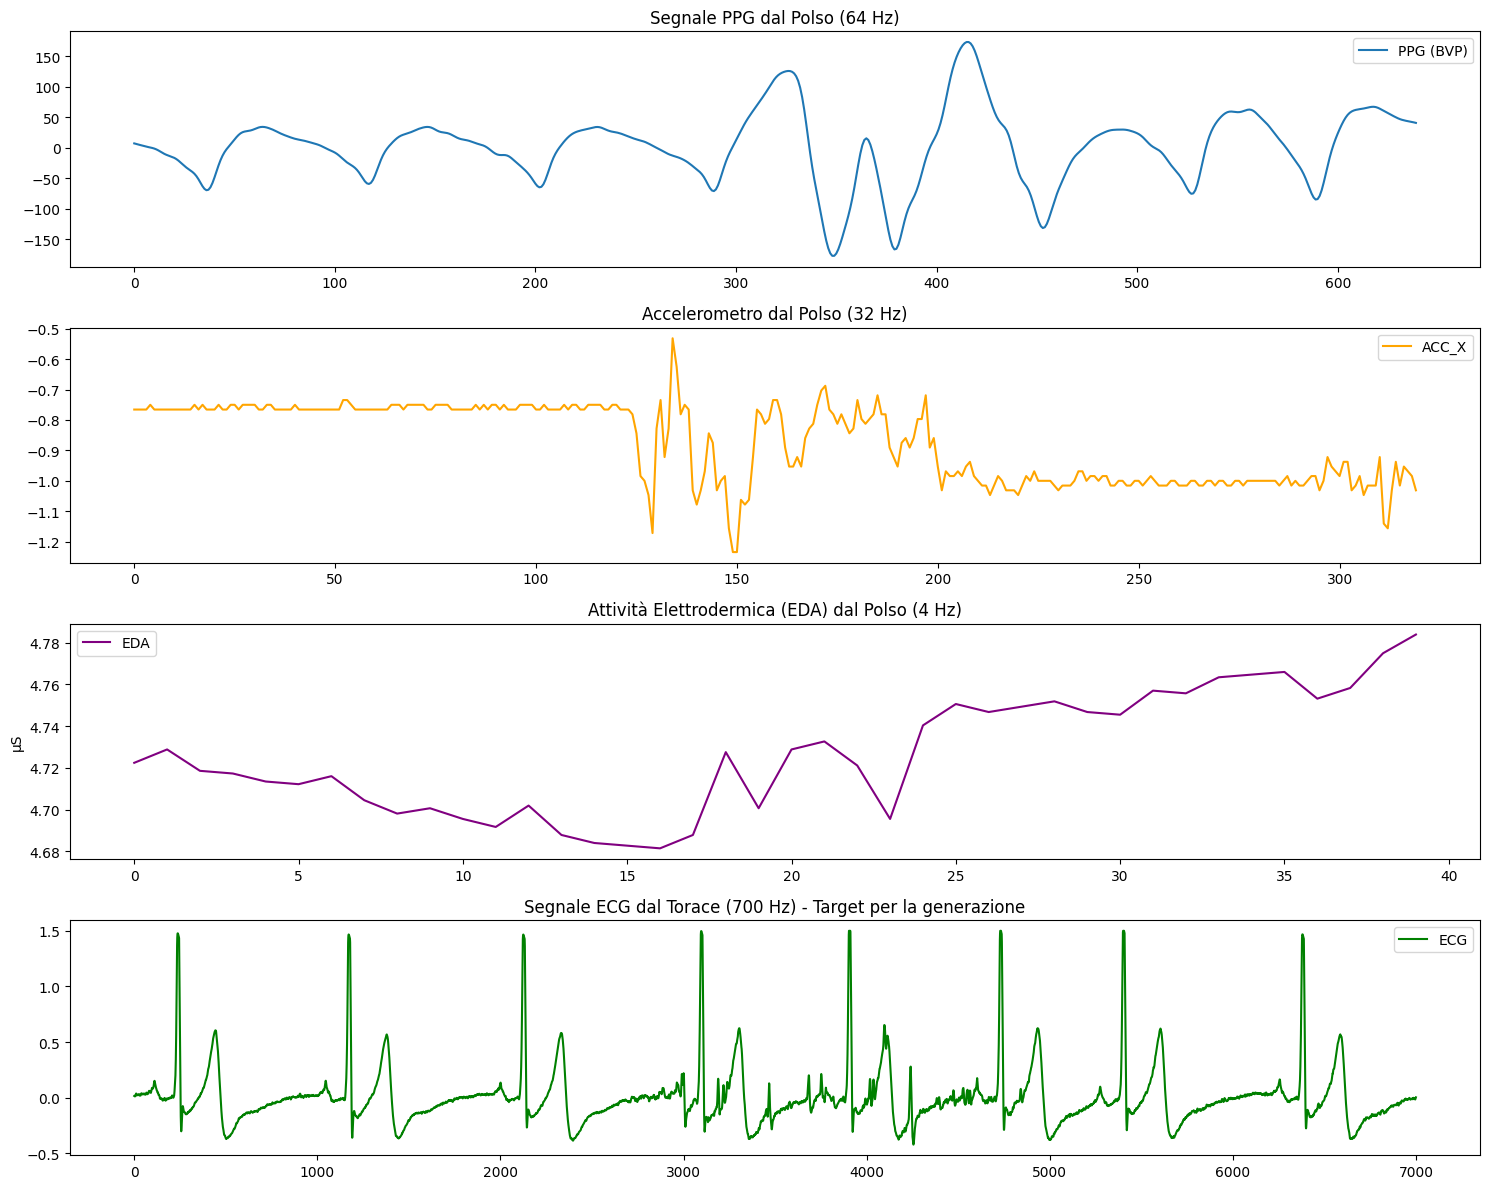

In [7]:
# Frequenze di campionamento dai documenti tecnici
fs_ppg = 64
fs_acc = 32
fs_eda = 4   # Frequenza EDA specificata nel dataset 
fs_ecg = 700
seconds = 10

# Aumentiamo l'altezza della figura per ospitare 4 grafici
plt.figure(figsize=(15, 12))

# 1. Plot PPG (BVP)
plt.subplot(4, 1, 1)
plt.plot(wrist_signals['BVP'][:seconds*fs_ppg], label='PPG (BVP)')
plt.title('Segnale PPG dal Polso (64 Hz)') 
plt.legend()

# 2. Plot ACC (solo asse X)
plt.subplot(4, 1, 2)
plt.plot(wrist_signals['ACC'][:seconds*fs_acc, 0], color='orange', label='ACC_X')
plt.title('Accelerometro dal Polso (32 Hz)') 
plt.legend()

# 3. Plot EDA (Novità)
plt.subplot(4, 1, 3)
# I dati EDA sono contenuti nel dizionario 'wrist' [cite: 121]
plt.plot(wrist_signals['EDA'][:seconds*fs_eda], color='purple', label='EDA')
plt.title('Attività Elettrodermica (EDA) dal Polso (4 Hz)') 
plt.ylabel('µS') # Unità di misura indicata nel dataset 
plt.legend()

# 4. Plot ECG (Ground Truth)
plt.subplot(4, 1, 4)
plt.plot(chest_signals['ECG'][:seconds*fs_ecg], color='green', label='ECG')
plt.title('Segnale ECG dal Torace (700 Hz) - Target per la generazione') 
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
print(f"Informazioni attività: {data['activity']}") 
# visualizzo quanti valori differenti sono contenuti nell'numpy.ndarray data['activity']
unique_activities = np.unique(data['activity'])
print(f"Attività uniche registrate: {unique_activities}")

Informazioni attività: [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
Attività uniche registrate: [0. 1. 2. 3. 4. 5. 6. 7. 8.]


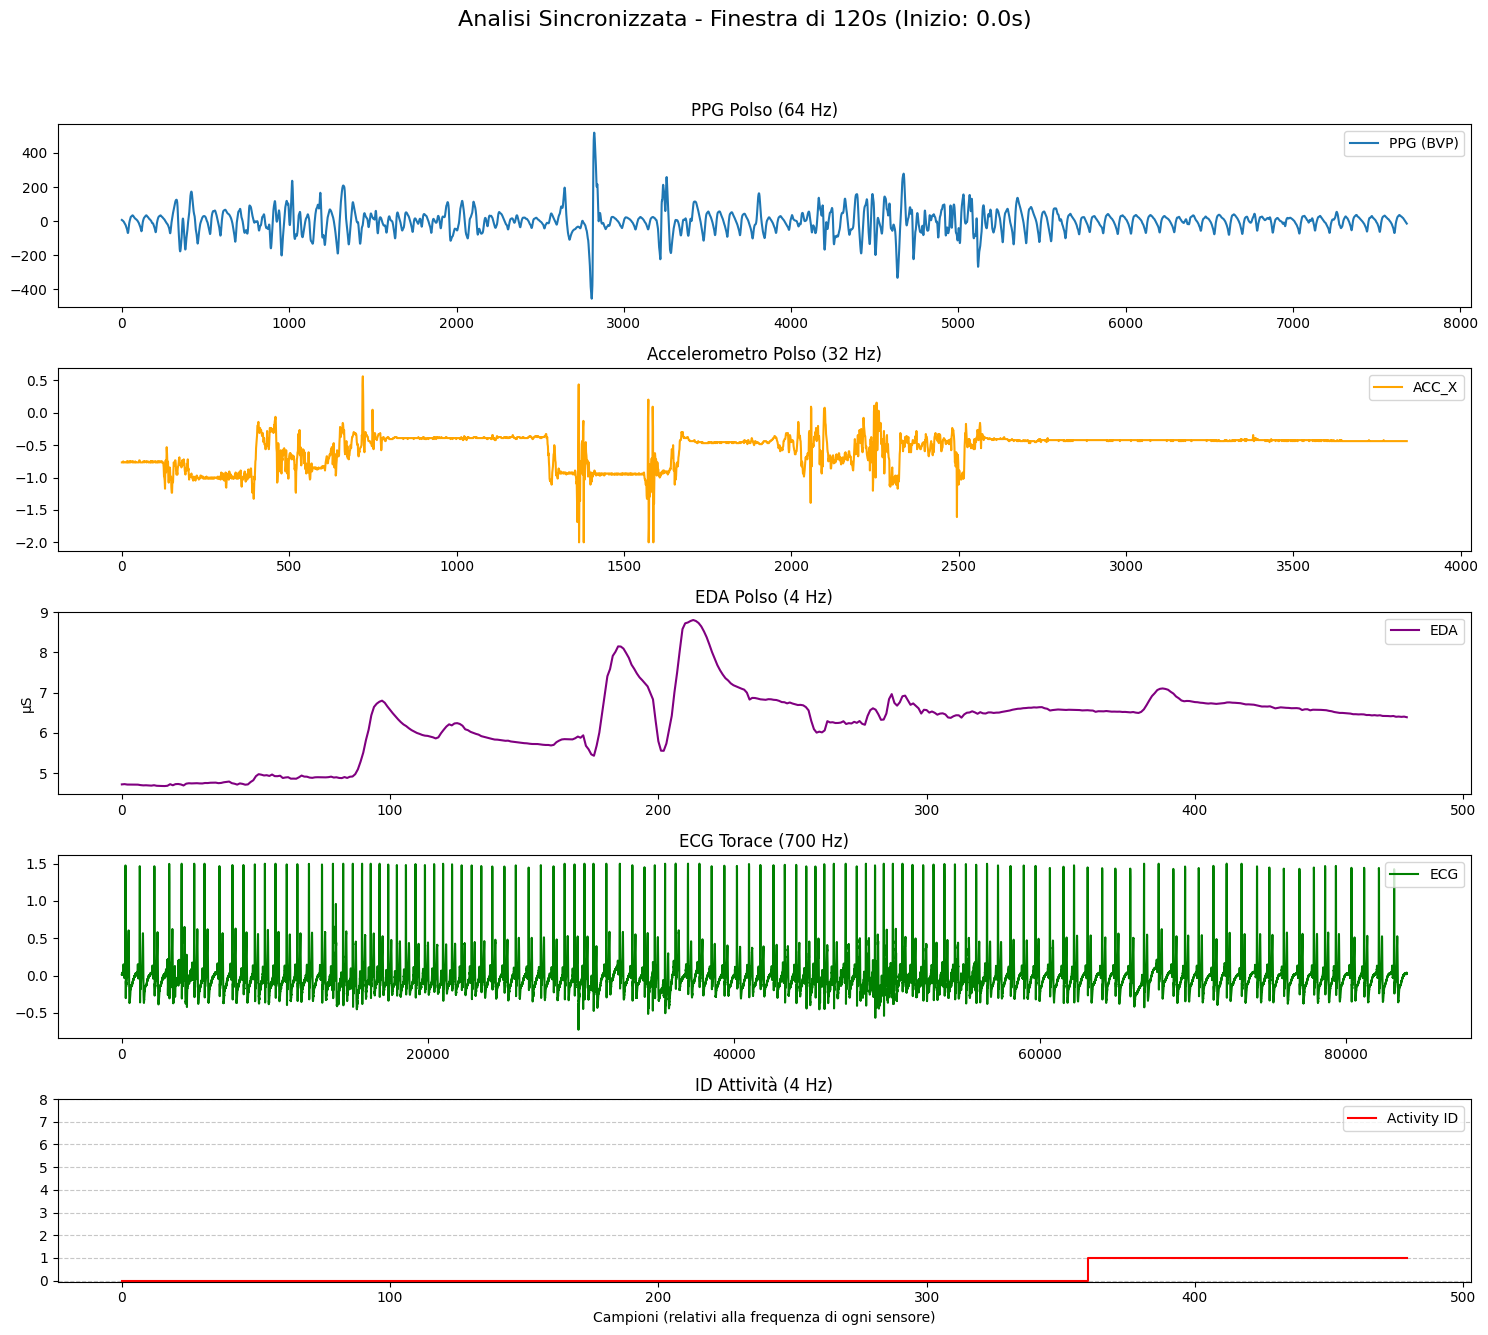

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Trova i momenti in cui l'attività è 0 (Transient Periods)
activity_signal = data['activity']
fs_activity = 4  # Frequenza del segnale activity nel .pkl 

indices_0 = np.where(activity_signal == 0)[0]

if len(indices_0) == 0:
    print("Nessun periodo con activity=0 trovato.")
else:
    # Selezione della finestra temporale
    start_idx_4hz = indices_0[0]
    start_time_sec = start_idx_4hz / fs_activity
    duration_sec = 120

    # 2. Frequenze di campionamento
    fs_ppg = 64
    fs_acc = 32
    fs_eda = 4
    fs_ecg = 700

    # 3. Calcolo intervalli sincronizzati
    ppg_slice = wrist_signals['BVP'][int(start_time_sec * fs_ppg) : int((start_time_sec + duration_sec) * fs_ppg)]
    acc_slice = wrist_signals['ACC'][int(start_time_sec * fs_acc) : int((start_time_sec + duration_sec) * fs_acc), 0]
    eda_slice = wrist_signals['EDA'][int(start_time_sec * fs_eda) : int((start_time_sec + duration_sec) * fs_eda)]
    ecg_slice = chest_signals['ECG'][int(start_time_sec * fs_ecg) : int((start_time_sec + duration_sec) * fs_ecg)]
    act_slice = activity_signal[int(start_time_sec * fs_activity) : int((start_time_sec + duration_sec) * fs_activity)]

    # 4. Visualizzazione (5 subplot)
    plt.figure(figsize=(15, 14))
    plt.suptitle(f"Analisi Sincronizzata - Finestra di {duration_sec}s (Inizio: {start_time_sec}s)", fontsize=16)

    # PPG
    plt.subplot(5, 1, 1)
    plt.plot(ppg_slice, label='PPG (BVP)')
    plt.title(f'PPG Polso ({fs_ppg} Hz)')
    plt.legend(loc='upper right')

    # ACC
    plt.subplot(5, 1, 2)
    plt.plot(acc_slice, color='orange', label='ACC_X')
    plt.title(f'Accelerometro Polso ({fs_acc} Hz)')
    plt.legend(loc='upper right')

    # EDA
    plt.subplot(5, 1, 3)
    plt.plot(eda_slice, color='purple', label='EDA')
    plt.title(f'EDA Polso ({fs_eda} Hz)')
    plt.ylabel('µS')
    plt.legend(loc='upper right')

    # ECG
    plt.subplot(5, 1, 4)
    plt.plot(ecg_slice, color='green', label='ECG')
    plt.title(f'ECG Torace ({fs_ecg} Hz)')
    plt.legend(loc='upper right')

    # ATTIVITÀ (Nuovo grafico)
    plt.subplot(5, 1, 5)
    plt.step(range(len(act_slice)), act_slice, where='post', color='red', label='Activity ID')
    plt.title(f'ID Attività ({fs_activity} Hz)')
    plt.yticks(range(9)) # Mostra gli ID da 0 a 8 
    plt.xlabel('Campioni (relativi alla frequenza di ogni sensore)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(loc='upper right')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

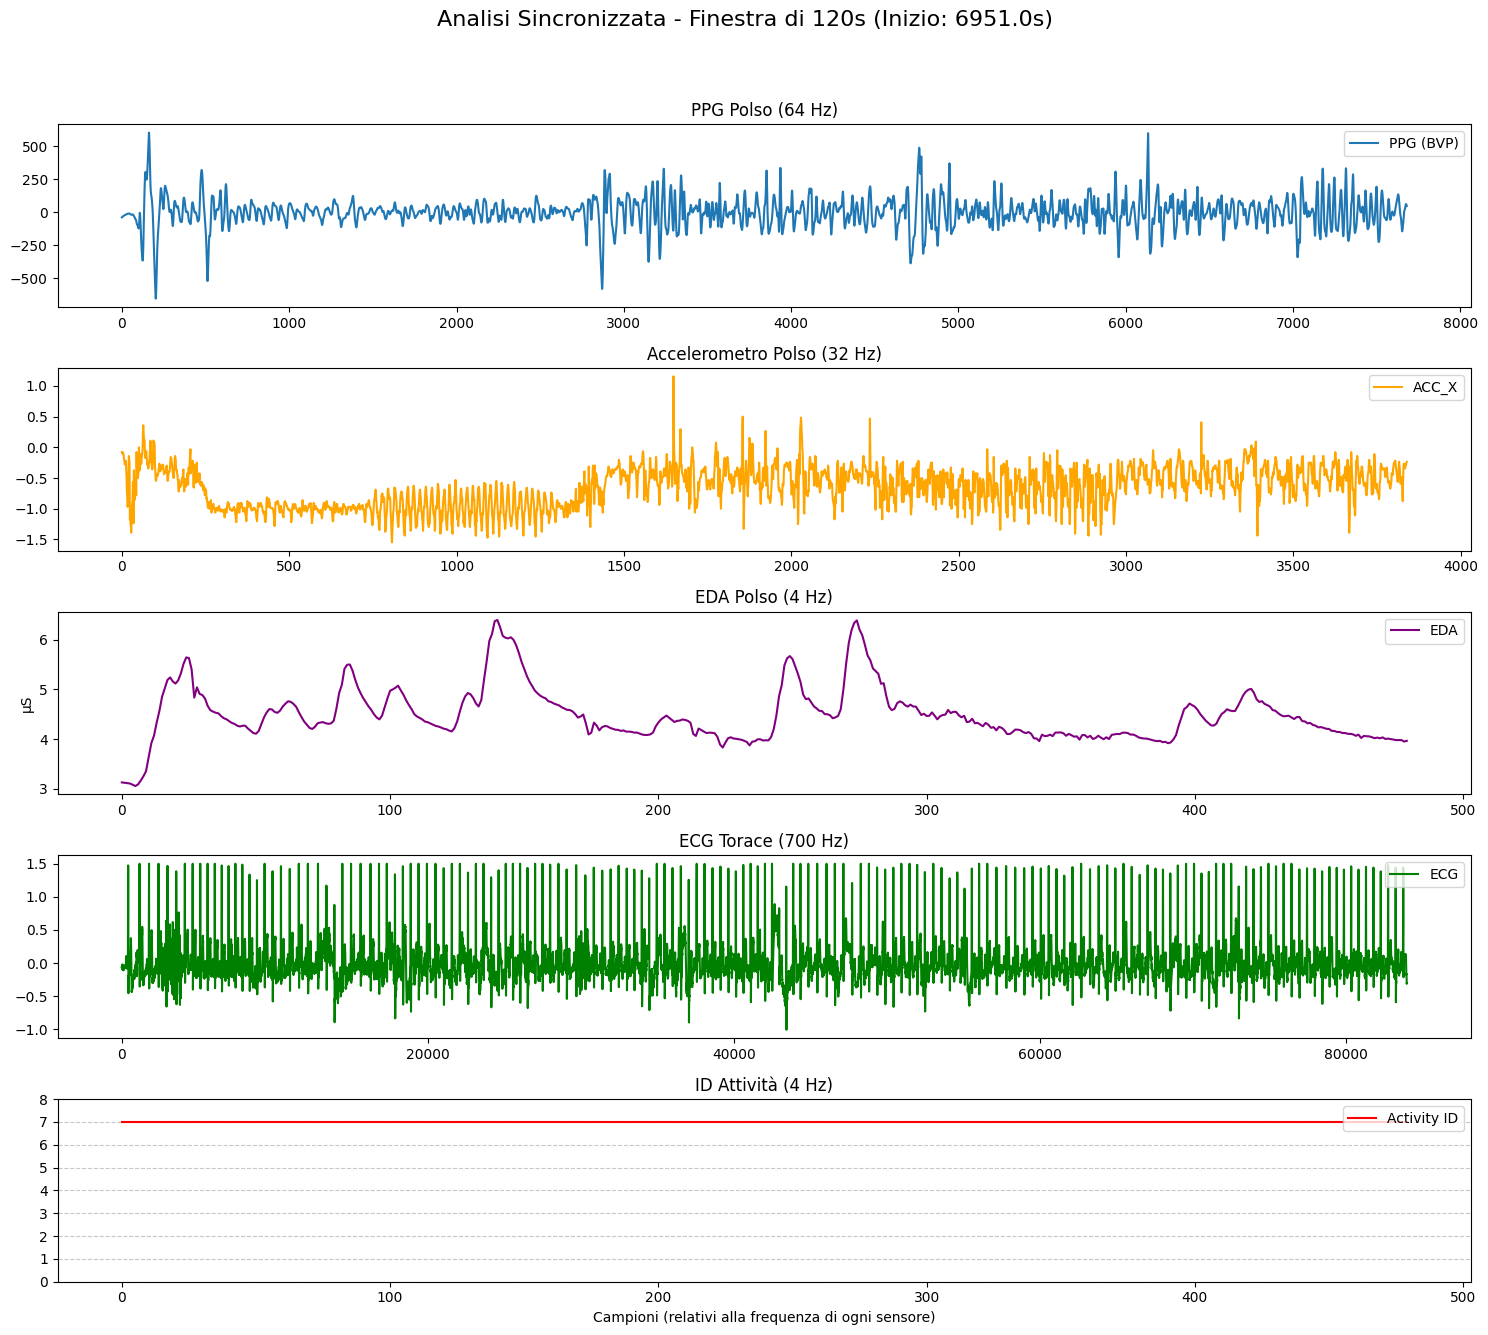

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Trova i momenti in cui l'attività è 0 (Transient Periods)
activity_signal = data['activity']
fs_activity = 4  # Frequenza del segnale activity nel .pkl 

indices_0 = np.where(activity_signal == 7)[0]

if len(indices_0) == 0:
    print("Nessun periodo con activity=7 trovato.")
else:
    # Selezione della finestra temporale
    start_idx_4hz = indices_0[0]
    start_time_sec = start_idx_4hz / fs_activity
    duration_sec = 120

    # 2. Frequenze di campionamento
    fs_ppg = 64
    fs_acc = 32
    fs_eda = 4
    fs_ecg = 700

    # 3. Calcolo intervalli sincronizzati
    ppg_slice = wrist_signals['BVP'][int(start_time_sec * fs_ppg) : int((start_time_sec + duration_sec) * fs_ppg)]
    acc_slice = wrist_signals['ACC'][int(start_time_sec * fs_acc) : int((start_time_sec + duration_sec) * fs_acc), 0]
    eda_slice = wrist_signals['EDA'][int(start_time_sec * fs_eda) : int((start_time_sec + duration_sec) * fs_eda)]
    ecg_slice = chest_signals['ECG'][int(start_time_sec * fs_ecg) : int((start_time_sec + duration_sec) * fs_ecg)]
    act_slice = activity_signal[int(start_time_sec * fs_activity) : int((start_time_sec + duration_sec) * fs_activity)]

    # 4. Visualizzazione (5 subplot)
    plt.figure(figsize=(15, 14))
    plt.suptitle(f"Analisi Sincronizzata - Finestra di {duration_sec}s (Inizio: {start_time_sec}s)", fontsize=16)

    # PPG
    plt.subplot(5, 1, 1)
    plt.plot(ppg_slice, label='PPG (BVP)')
    plt.title(f'PPG Polso ({fs_ppg} Hz)')
    plt.legend(loc='upper right')

    # ACC
    plt.subplot(5, 1, 2)
    plt.plot(acc_slice, color='orange', label='ACC_X')
    plt.title(f'Accelerometro Polso ({fs_acc} Hz)')
    plt.legend(loc='upper right')

    # EDA
    plt.subplot(5, 1, 3)
    plt.plot(eda_slice, color='purple', label='EDA')
    plt.title(f'EDA Polso ({fs_eda} Hz)')
    plt.ylabel('µS')
    plt.legend(loc='upper right')

    # ECG
    plt.subplot(5, 1, 4)
    plt.plot(ecg_slice, color='green', label='ECG')
    plt.title(f'ECG Torace ({fs_ecg} Hz)')
    plt.legend(loc='upper right')

    # ATTIVITÀ (Nuovo grafico)
    plt.subplot(5, 1, 5)
    plt.step(range(len(act_slice)), act_slice, where='post', color='red', label='Activity ID')
    plt.title(f'ID Attività ({fs_activity} Hz)')
    plt.yticks(range(9)) # Mostra gli ID da 0 a 8 
    plt.xlabel('Campioni (relativi alla frequenza di ogni sensore)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(loc='upper right')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()